We are trying to solve: <br><br>
$\frac{\partial u(x,y,z)}{\partial x} = A(\frac{\partial^{2} u}{\partial z^{2}}+\frac{\partial^{2} u}{\partial y^{2}}) + F(x,y,z)u$<br><br><br>
Using ADI, this becomes two half step updates (eq 3.25, [Fuhse thesis](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=2ahUKEwj11OzNzOXdAhWM1IMKHQeFBfwQFjAAegQICRAC&url=https%3A%2F%2Fediss.uni-goettingen.de%2Fbitstream%2Fhandle%2F11858%2F00-1735-0000-0006-B592-3%2Ffuhse.pdf%3Fsequence%3D1&usg=AOvVaw1HRt8mkDnQc_LoM-RhOpcu)), with the first one being : <br><br>
$(1-\frac{r_{y}}{2}\delta^{2}_{y}+C^{n+\frac{1}{2}}_{jk})*u^{n+\frac{1}{2}}_{jk} = (1+\frac{r_{z}}{2}\delta^{2}_{z}+C^{n}_{jk})*u^{n}_{jk}$<br><br>
This can be written as a series of linear matrix equations :<br><br>
$B^{n}_{k}*u^{n+\frac{1}{2}}_{k} = r_{k}$, for $k = 1,....., M_{z}-1$<br><br>
and for the second half step, it becomes:<br><br>
$B^{'n}_{j}*u^{n+1}_{j} = r^{'}_{j}$, for $k = 1,....., M_{z}-1$<br>
<br><br>
Define: <br><br>
$r_{y} = A\frac{\Delta x}{\Delta y^{2}}$<br>
$r_{z} = A\frac{\Delta x}{\Delta z^{2}}$<br>
$C^{n}_{jk} = \frac{F^{n}_{k}\Delta x}{4}$<br>
$A = \frac{-i}{2k}$<br>
$F(x,y,z) = -1*\frac{ik}{2}(n^{2}(x,y,z)-1)$

In [1]:
import numpy as np
import urllib
import matplotlib.pyplot as plt
from skimage.restoration import unwrap_phase
from tqdm import trange
from scipy.signal import gaussian
from scipy.sparse import diags
import scipy.sparse.linalg as splinalg
np.set_printoptions(2)

In [6]:
def get_property(mat,energy):
    url = "http://henke.lbl.gov/cgi-bin/pert_cgi.pl"
    data = {'Element':str(mat), 'Energy':str(energy), 'submit':'Submit Query'}
    data = urllib.parse.urlencode(data)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    resp = urllib.request.urlopen(req)
    respDat = resp.read()
    response = respDat.split()
    d =  b'g/cm^3<li>Delta'
    i = response.index(d)
    delta = str(response[i+2])[:str(response[i+2]).index('<li>Beta')][2:]
    beta = str(response[i+4])[2:-1]
    return float(delta),float(beta)

In [7]:
π = np.pi
E = 10000
λ = (1239.84/E)*1e-9
k = ((2*π)/λ)
A = -1j/(2*k)
n_au = 1 - get_property('Au',E)[0] - 1j*get_property('Au',E)[1]

In [10]:
dim_x = 500
dim_y = 500
dim_z = 500

x = np.linspace(0,5e-3,dim_x)
y = np.linspace(-4e-6,4e-6,dim_z)
z = np.linspace(-4e-6,4e-6,dim_z)

Δx = x[1] - x[0]
Δy = y[1] - y[0]
Δz = z[1] - z[0]

r_y = A * (Δx/(Δy)**2) 
r_z = A * (Δx/(Δz)**2) 

In [12]:
wave = np.zeros((dim_y,dim_z),dtype=np.complex128)
Y,Z = np.meshgrid(y,z)
loc_wave = np.where(np.logical_and(np.abs(Z)<0.5e-6,np.abs(Y)<0.5e-6))
wave[loc_wave] = 1
wave_history = np.zeros((dim_y,dim_z,dim_x),dtype=np.complex128)

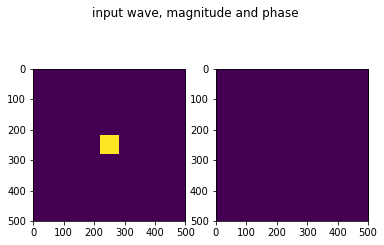

In [16]:
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(wave))
ax2.imshow(unwrap_phase(np.angle(wave)))
fig.suptitle('input wave, magnitude and phase')
plt.show()

In [20]:
for i in trange(dim_x):
    ##Step 1
    for i in range(dim_z-2):
        '''
        c = np.ones(dim_z-2)
        d = c*wave[1:-1] + 0.5*r_z*wave[2:] + 0.5*r_z*wave[:-2]
        d[0]  += r_z*wave[0]
        d[-1] += r_z*wave[-1]
        b_diag = np.ones(dim_z-2)*(1 + r_z)
        B = diags(b_diag,offsets=0) + diags(-r_z/2*np.ones(dim_z-3),offsets=1) + diags(-r_z/2*np.ones(dim_z-3),offsets=-1)
        wave[1:-1] = splinalg.spsolve(B,d)
        '''
    ##Step 2
    for i in range(dim_z):
        pass
    
wave_history[1:-1,i] = wave[1:-1]

100%|██████████| 500/500 [00:00<00:00, 26209.81it/s]


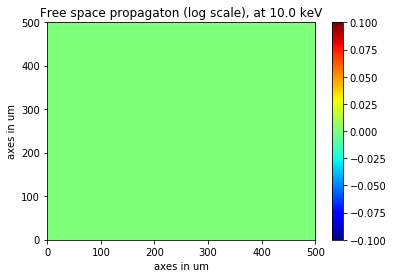

In [23]:
plt.imshow(np.log(np.abs(wave_history[-1,:,:])**2+1),origin='lower',aspect='auto',cmap='jet')
plt.colorbar()
plt.xlabel('axes in um')
plt.ylabel('axes in um')
plt.title('Free space propagaton (log scale), at '+str(round(E*1e-3,3))+' keV')
plt.rcParams["figure.figsize"] = (8,8)
plt.show()

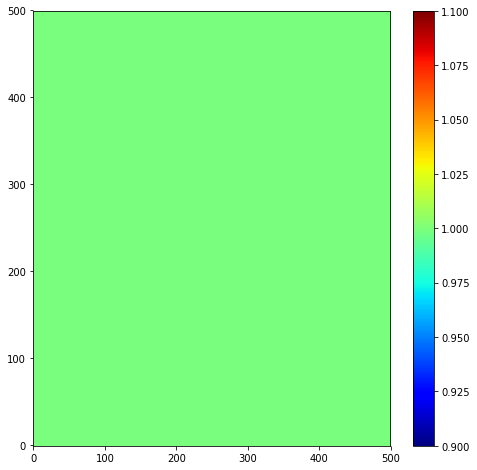

In [24]:
plt.imshow((np.abs(wave_history[-1,:,:])**2+1),origin='lower',aspect='auto',cmap='jet')
plt.colorbar()
plt.show()